<a href="https://colab.research.google.com/github/giacomobinco/FDS-Final-Project/blob/main/fma_dataset585000VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms, datasets


In [2]:
# Cloning the GitHub repos of the "fma_small" dataset and the metadata
# [ !! It takes about 5 minutes !! ]

!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2025-12-17 18:08:43--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  23.2MB/s    in 5m 46s  

2025-12-17 18:14:30 (21.2 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]

--2025-12-17 18:14:30--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81

In [3]:
# Unzipping the two folders previously loaded
# [ !! It takes about 15 minutes !! ]

for zip_path in ["fma_small.zip", "fma_metadata.zip"]:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall()

In [4]:
AUDIO_DIR = "fma_small"
files = []

for root, dirs, filenames in os.walk(AUDIO_DIR):
    for f in filenames:
        if f.lower().endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"{len(files)} file MP3 trovati")
print(files[:5])


8000 file MP3 trovati
['fma_small/109/109976.mp3', 'fma_small/109/109686.mp3', 'fma_small/109/109543.mp3', 'fma_small/109/109711.mp3', 'fma_small/109/109535.mp3']


In [5]:
# Generating four tables (from the metadata) with information regarding the 8.000 audio tracks

tracks = pd.read_csv('fma_metadata/tracks.csv', index_col = 0, header = [0, 1])
genres = pd.read_csv('fma_metadata/genres.csv', index_col = 0)
features = pd.read_csv('fma_metadata/features.csv', index_col = 0, header = [0, 1, 2])
echonest = pd.read_csv('fma_metadata/echonest.csv', index_col = 0, header = [0, 1, 2])

# Printing their shape to check if they've been correctly generated

print("Tracks:", tracks.shape)
print("Genres:", genres.shape)
print("Features:", features.shape)
print("Echonest:", echonest.shape)

Tracks: (106574, 52)
Genres: (163, 4)
Features: (106574, 518)
Echonest: (13129, 249)


ChatGPT regarding the file *features.csv*:

"Sono feature pre-estratte dall’audio usando *librosa*, ma non sono spettrogrammi completi. Non sono dunque adatte per CNN: non sono matrici tempo-frequenza, quanto più valori aggregati."

In [6]:
audio_dir = "fma_small"
files = []

for root, dirs, filenames in os.walk(audio_dir):
    for f in filenames:
        if f.endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"----- {len(files)} audio tracks found -----")


----- 8000 audio tracks found -----


In [7]:
#UPLOADING THE SPECTOGRAM FOLDER
zip_path = "fma_spectrograms.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("fma_spectrograms")
print("✓ ZIP estratto con successo!")



✓ ZIP estratto con successo!


In [8]:
# Cartella dove vogliamo estrarre le immagini
OUTPUT_DIR = "fma_spectrograms_clean"
os.makedirs(OUTPUT_DIR, exist_ok=True)

with zipfile.ZipFile("fma_spectrograms.zip", "r") as zip_ref:
    # ZIP potrebbe contenere una cartella interna
    for member in zip_ref.namelist():
        # Rimuove eventuale cartella interna (solo il nome del file)
        filename = os.path.basename(member)
        if filename:  # evita le cartelle vuote
            # Scrive direttamente nella nostra cartella OUTPUT_DIR
            source = zip_ref.open(member)
            target_path = os.path.join(OUTPUT_DIR, filename)
            with open(target_path, "wb") as target:
                with source as src:
                    target.write(src.read())

# Controllo
print("Prime immagini estratte:", os.listdir(OUTPUT_DIR)[:5])


Prime immagini estratte: ['4073_International.png', '72783_Hip-Hop.png', '47197_Experimental.png', '23041_Rock.png', '1733_Experimental.png']


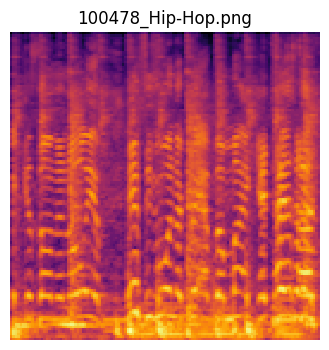

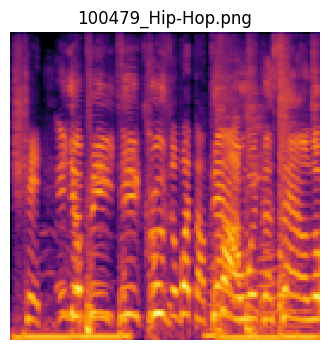

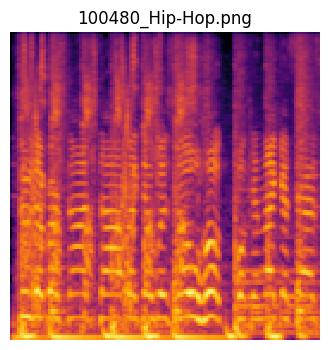

In [ ]:
img_files = sorted(os.listdir(OUTPUT_DIR))[:3]

for img_file in img_files:
    img_path = os.path.join(OUTPUT_DIR, img_file)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()



In [9]:
#CNN works better if the dataset is organized in folders
#Folder Organization
spectrogram_dir = "fma_spectrograms_clean"
dataset_dir = "dataset"
os.makedirs(dataset_dir, exist_ok=True)

tracks = pd.read_csv("fma_metadata/tracks.csv", index_col=0, header=[0,1])

copied = 0
skipped = 0

for fname in os.listdir(spectrogram_dir):
    if not fname.lower().endswith(".png"):
        continue

    track_id_str = fname.split("_")[0]

    try:
        track_id = int(track_id_str)
    except:
        skipped += 1
        continue

    if track_id not in tracks.index:
        skipped += 1
        continue

    genre = tracks.loc[track_id, ('track','genre_top')]
    genre_dir = os.path.join(dataset_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)

    shutil.copy(os.path.join(spectrogram_dir, fname), os.path.join(genre_dir, fname))
    copied += 1

print(f"✅ Copiati {copied} file nelle cartelle dei generi")
print(f"⚠️ Saltati {skipped} file senza corrispondenza")




✅ Copiati 7997 file nelle cartelle dei generi
⚠️ Saltati 0 file senza corrispondenza


In [10]:
#Check if the file are distrbituited correctly
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)[:5]
        print(f"{genre}: {files}")


Electronic: ['70302_Electronic.png', '124918_Electronic.png', '140923_Electronic.png', '105670_Electronic.png', '113335_Electronic.png']
Experimental: ['47197_Experimental.png', '1733_Experimental.png', '133332_Experimental.png', '21774_Experimental.png', '74377_Experimental.png']
Folk: ['40245_Folk.png', '45516_Folk.png', '91238_Folk.png', '144468_Folk.png', '23015_Folk.png']
Hip-Hop: ['72783_Hip-Hop.png', '123965_Hip-Hop.png', '147268_Hip-Hop.png', '112484_Hip-Hop.png', '72234_Hip-Hop.png']
Instrumental: ['126018_Instrumental.png', '126181_Instrumental.png', '116489_Instrumental.png', '122634_Instrumental.png', '124181_Instrumental.png']
International: ['4073_International.png', '24702_International.png', '13539_International.png', '44822_International.png', '110448_International.png']
Pop: ['53229_Pop.png', '58116_Pop.png', '35545_Pop.png', '141181_Pop.png', '19418_Pop.png']
Rock: ['23041_Rock.png', '75784_Rock.png', '105912_Rock.png', '97690_Rock.png', '136094_Rock.png']


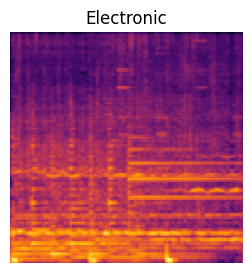

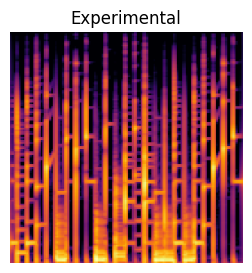

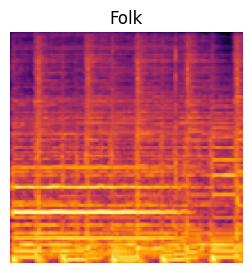

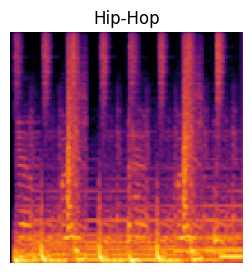

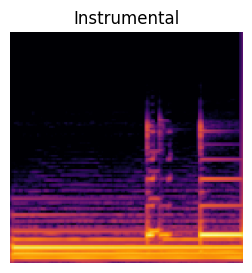

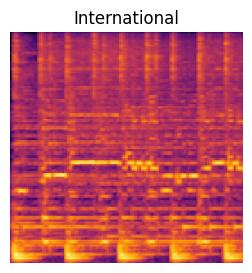

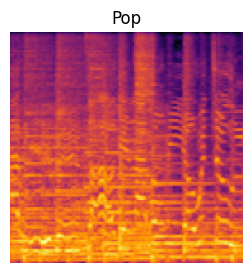

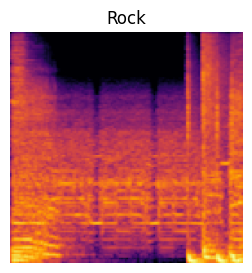

In [ ]:
#Visualization of one image per genre
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)
        if files:
            img_path = os.path.join(genre_path, files[0])
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6,3))
            plt.imshow(img)
            plt.axis('off')
            plt.title(genre)
            plt.show()


We can clearly see that all  the spectrograms, besides the one for the "Rock" genre, are quite similar.
The spectrogram rapresenting a "Rock" song is clearly not as noisy as the spectrograms rapresenting all the other genres

In [14]:
import numpy as np
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.transforms import functional as F
from torch.utils.data import WeightedRandomSampler


import torch
import random

class TimeMask:
    def __init__(self, T=40):
        self.T = T

    def __call__(self, x):
        # x deve essere un Tensor di forma [Canali, Freq, Tempo]
        # x.shape = [C, H, W]
        _, _, W = x.shape
        # Scegliamo una larghezza random per la maschera
        t = random.randint(0, self.T)
        # Scegliamo il punto di inizio random
        t0 = random.randint(0, max(0, W - t))
        # Mascheriamo (asse del tempo è l'ultimo, W)
        x[:, :, t0:t0+t] = 0
        return x

class FreqMask:
    def __init__(self, F=30):
        self.F = F

    def __call__(self, x):
        # x deve essere un Tensor di forma [Canali, Freq, Tempo]
        # x.shape = [C, H, W]
        _, H, _ = x.shape
        f = random.randint(0, self.F)
        f0 = random.randint(0, max(0, H - f))
        # Mascheriamo (asse della frequenza è il centrale, H)
        x[:, f0:f0+f, :] = 0
        return x
# --------------------------
# Data Augmentation
# --------------------------
# --- CERCA QUESTA PARTE E MODIFICALA COSÌ ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomApply([TimeMask(T=30)], p=0.25),
    transforms.RandomApply([FreqMask(F=20)], p=0.25),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


# Il validation transform rimane semplice
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
dataset_dir = "/content/dataset"  # cambia se serve
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transform)
val_dataset_raw = datasets.ImageFolder(dataset_dir, transform=val_transform)
raw_dataset = datasets.ImageFolder(dataset_dir)
num_classes = len(raw_dataset.classes)
full_indices = list(range(len(raw_dataset)))


In [15]:
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_idx, val_idx = torch.utils.data.random_split(full_indices, [train_size, val_size])

# Creiamo due istanze separate per applicare trasformazioni diverse
train_dataset_full = datasets.ImageFolder(dataset_dir, transform=train_transform)
val_dataset_full   = datasets.ImageFolder(dataset_dir, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset   = Subset(val_dataset_full, val_idx)

# DataLoader: Shuffle=True per il train (FMA Small è bilanciato, niente sampler pesato)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)



In [16]:
def mixup(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx], lam)


def mixup_loss(criterion, pred, targets):
    y1, y2, lam = targets
    return lam * criterion(pred, y1) + (1 - lam) * criterion(pred, y2)

In [17]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
# 8 classi
model = model.cuda()



In [18]:
from torch.amp import autocast, GradScaler

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW([
    {"params": model.heads.parameters(), "lr": 1e-3},
    {"params": [p for n,p in model.named_parameters() if "heads" not in n], "lr": 5e-5},
], weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)
scaler = GradScaler() # Aggiornato per le versioni recenti di PyTorch


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import copy

# ------------------------
# METRICHE (solo validation)
# ------------------------
def compute_metrics(y_true, y_pred):
    acc = (y_true == y_pred).mean() * 100
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return acc, prec, rec, f1

# ------------------------
# TRAIN EPOCH (mixup attivo)
# ------------------------
def train_epoch(loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        images, mix_targets = mixup(images, labels)

        optimizer.zero_grad()
        with autocast("cuda"):
            preds = model(images)
            loss = mixup_loss(criterion, preds, mix_targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

# ------------------------
# VALIDATION
# ------------------------
def validate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            with autocast("cuda"):
                preds = model(images)
                loss = criterion(preds, labels)
            total_loss += loss.item()
            all_preds.append(preds.argmax(1).cpu())
            all_labels.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    acc, prec, rec, f1 = compute_metrics(y_true, y_pred)
    return total_loss / len(loader), acc, prec, rec, f1

# ------------------------
# TRAINING LOOP (12 epoche)
# ------------------------
print("\n🚀 FINE-TUNING CON MIXUP — 12 epoche")

EPOCHS = 12
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = GradScaler()

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(val_loader)
    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        save_msg = "🏆 BEST"
    else:
        save_msg = ""

    print(
        f"[Ep {epoch:02d}] Train Loss {train_loss:.4f} || "
        f"Val Acc {val_acc:.2f}% | P {val_prec:.3f} | R {val_rec:.3f} | F1 {val_f1:.3f} {save_msg}"
    )

model.load_state_dict(best_model_wts)



🚀 FINE-TUNING CON MIXUP — 12 epoche
[Ep 01] Train Loss 1.8440 || Val Acc 46.75% | P 0.468 | R 0.471 | F1 0.443 🏆 BEST
[Ep 02] Train Loss 1.6518 || Val Acc 52.94% | P 0.536 | R 0.532 | F1 0.520 🏆 BEST
[Ep 03] Train Loss 1.5700 || Val Acc 54.00% | P 0.528 | R 0.545 | F1 0.528 🏆 BEST
[Ep 04] Train Loss 1.5366 || Val Acc 55.44% | P 0.573 | R 0.559 | F1 0.552 🏆 BEST
[Ep 05] Train Loss 1.4619 || Val Acc 56.25% | P 0.557 | R 0.569 | F1 0.551 🏆 BEST
[Ep 06] Train Loss 1.4483 || Val Acc 56.62% | P 0.563 | R 0.570 | F1 0.550 🏆 BEST
[Ep 07] Train Loss 1.3797 || Val Acc 55.62% | P 0.543 | R 0.559 | F1 0.536 
[Ep 08] Train Loss 1.3185 || Val Acc 57.50% | P 0.571 | R 0.580 | F1 0.563 🏆 BEST
[Ep 09] Train Loss 1.2310 || Val Acc 57.69% | P 0.570 | R 0.582 | F1 0.566 🏆 BEST
[Ep 10] Train Loss 1.2390 || Val Acc 57.00% | P 0.565 | R 0.573 | F1 0.565 
[Ep 11] Train Loss 1.1212 || Val Acc 58.88% | P 0.582 | R 0.591 | F1 0.583 🏆 BEST
[Ep 12] Train Loss 1.1299 || Val Acc 58.44% | P 0.580 | R 0.588 | F1 0.58

<All keys matched successfully>

5/5 Epoch , Loss: 1.075